In [74]:
import pandas as pd
from   sqlalchemy import create_engine
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import numpy as np
import plotly.express as px

In [3]:
# The data file path and file name need to be configured.
PATH     = "D:\\marese\\term 2\\Python Fundamentals for Data Analysis\\5\\"
CSV_DATA = "brazil_forestFires.csv"

In [4]:
# read the csv file into a DF and print the tail
df = pd.read_csv(PATH + CSV_DATA, skiprows=1,  encoding = "ISO-8859-1", sep=',',
                 names=('year', 'state',  'month', 'number','date', ))
print(df.tail(2))


      year      state     month  number        date
6213  2015  Tocantins  Dezembro   373.0  2015-01-01
6214  2016  Tocantins  Dezembro   119.0  2016-01-01


In [5]:
# for practice we create a sqlite DB and ingest the DF into the DB
DB_FILE    = 'forestFire.db'
engine     = create_engine('sqlite:///' + PATH + DB_FILE, echo=False)
connection = engine.connect()

# Store data in database in a table named 'brazilForest'. 
df.to_sql(name='brazilForest', con=connection, if_exists='replace', index=False)


In [6]:
# Placed query in this function to enable code re-usuability.
def showQueryResult(sql_query, dbconnection):
    print("\n*** Showing SQL statement")
    print(sql_query)
    # Perform query
    subDf = pd.read_sql(sql_query, dbconnection)
    return subDf



In [7]:
# Get DataFrame contents for 'Rio' and 'Sao Paulo' only.
sql1    = "SELECT * FROM " + "brazilForest" \
       + " WHERE state = 'Rio' OR state='Sao Paulo' " \
       + " ORDER BY date"
       
newDf = showQueryResult(sql1, connection)


*** Showing SQL statement
SELECT * FROM brazilForest WHERE state = 'Rio' OR state='Sao Paulo'  ORDER BY date


In [8]:
print(newDf)

     year      state      month   number        date
0    1998        Rio    Janeiro    0.000  1998-01-01
1    1998        Rio  Fevereiro    0.000  1998-01-01
2    1998        Rio      Março    0.000  1998-01-01
3    1998        Rio      Abril    0.000  1998-01-01
4    1998        Rio       Maio    0.000  1998-01-01
..    ...        ...        ...      ...         ...
951  2017  Sao Paulo      Julho  802.000  2017-01-01
952  2017  Sao Paulo     Agosto  981.000  2017-01-01
953  2017  Sao Paulo   Setembro    2.868  2017-01-01
954  2017  Sao Paulo    Outubro  179.000  2017-01-01
955  2017  Sao Paulo   Novembro   37.000  2017-01-01

[956 rows x 5 columns]


In [9]:
sql = "SELECT * FROM " + "brazilForest" \
       + " ORDER BY date"

In [10]:
newDf = showQueryResult(sql, connection)
newDf


*** Showing SQL statement
SELECT * FROM brazilForest ORDER BY date


,year,state,month,number,date
0,1998,Alagoas,Janeiro,0.000,1998-01-01
1,1998,Alagoas,Fevereiro,0.000,1998-01-01
2,1998,Alagoas,Março,0.000,1998-01-01
3,1998,Alagoas,Abril,0.000,1998-01-01
4,1998,Alagoas,Maio,0.000,1998-01-01
...,...,...,...,...,...
6210,2017,Tocantins,Julho,2.397,2017-01-01
6211,2017,Tocantins,Agosto,3.536,2017-01-01
6212,2017,Tocantins,Setembro,10.737,2017-01-01
6213,2017,Tocantins,Outubro,2.969,2017-01-01


# Data Cleaning
We can already see that there are non-integer values recorded as number of wildfires for some cities. This could be due to improper data recording, for now we will eliminate records that are not integer, but in a real problem we would have to gather some information about the data recording process and find the best method to replace/clean these values.
Another method we could use to replace these values, is by averaging the neighbouring years and replace the value with the integer part of that value.

In [11]:
def isInteger(num):
    if (num-int(num) == 0):
        return True
    else:
        return False

In [12]:
# eliminate all records with non-integer "number"s
newDf['isInteger'] = newDf['number'].apply(isInteger)

In [13]:
newDf = newDf[newDf["isInteger"] == True]

We can see that we eliminated almost around 1000 data points by removing non-integer numbers. 
Now we want to look at the trend of forest fires over the years in different states.

In [14]:
# We group the number of fires in each state for each year
grouped_df = newDf.groupby(by=['year','state']).sum()
grouped_df

number  isInteger
year state                            
1998 Alagoas           86.0         12
     Amapa            278.0         12
     Amazonas         946.0         12
     Bahia           1220.0         10
     Ceara           1611.0         11
...                     ...        ...
2017 Roraima         1101.0         11
     Santa Catarina  2354.0         11
     Sao Paulo       2538.0         10
     Sergipe           75.0         11
     Tocantins       1358.0          6

[440 rows x 2 columns]

In [16]:
# reset index to flatten the dataframe
grouped_df.reset_index(inplace=True)

In [33]:
limited_grouped_df = grouped_df[grouped_df['number']>500]

In [34]:
limited_grouped_df['year'] = pd.to_datetime(grouped_df['year'], format='%Y')

<ipython-input-34-9ea9fa04967e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_grouped_df['year'] = pd.to_datetime(grouped_df['year'], format='%Y')


Text(0, 0.5, 'Number of incidents')

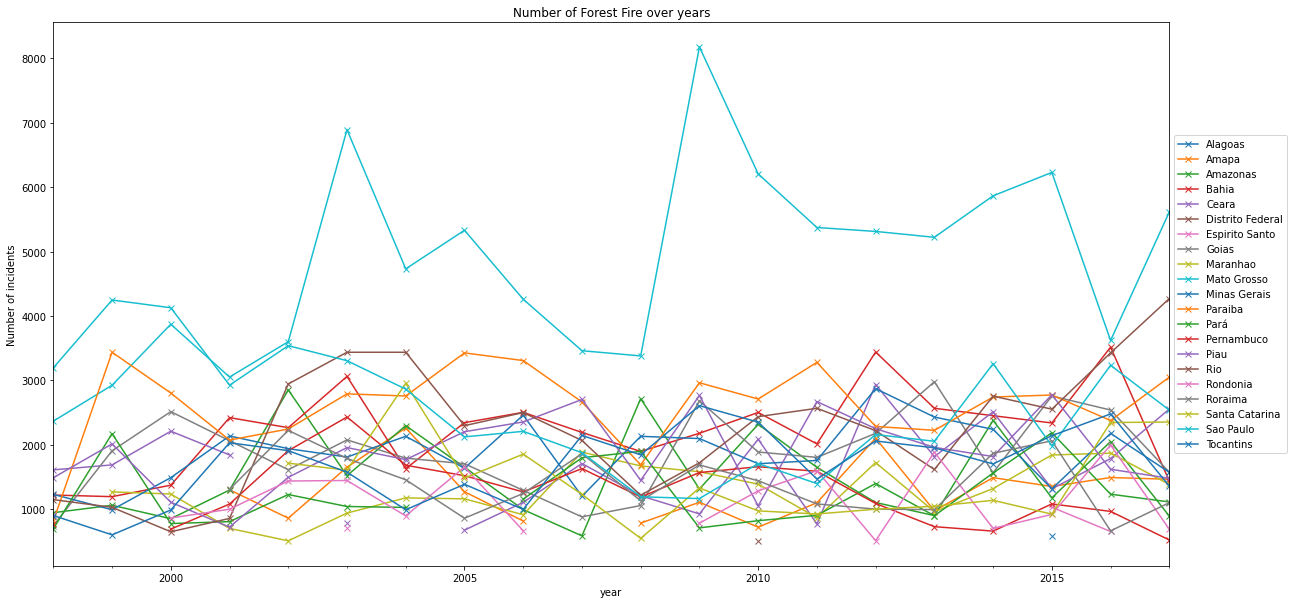

In [35]:
limited_grouped_df.pivot(index='year', columns='state', values='number').plot(figsize=(20,10), marker='x')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Number of Forest Fire over years")
plt.ylabel("Number of incidents")

In [38]:
# to identify which blue color on the graph is Sao Paulo we look at the first datapoint
limited_grouped_df[limited_grouped_df['state'] =='Sao Paulo'].head()

,year,state,number,isInteger
19,1998-01-01,Sao Paulo,3196.0,12
41,1999-01-01,Sao Paulo,4248.0,11
63,2000-01-01,Sao Paulo,4128.0,12
85,2001-01-01,Sao Paulo,2926.0,12
107,2002-01-01,Sao Paulo,3539.0,12


In [39]:
limited_grouped_df[limited_grouped_df['state'] =='Mato Grosso'].head()

,year,state,number,isInteger
9,1998-01-01,Mato Grosso,2367.0,19
31,1999-01-01,Mato Grosso,2925.0,14
53,2000-01-01,Mato Grosso,3872.0,18
75,2001-01-01,Mato Grosso,3052.0,16
97,2002-01-01,Mato Grosso,3601.0,12


Looking at graph above, we do not see a positive trend of forest fires across the states. We can see, however that the state of Mato Grosso has seen more forest fires consistently. This graph could be used to give a rough estimate of how forest fire prevention facilities might be allocated based on the number of incidents.

In [41]:
# we use Nominatim API to find lon lat of different states
geolocator = Nominatim(user_agent="MyApp")

In [60]:
location = geolocator.geocode("Amazonas")

In [61]:
location.latitude

-4.479925

In [46]:
location.longitude

-55.5716547

In [56]:
# now we create lat lon columns for the whole dataframe
limited_grouped_df['latitude'] = np.zeros(len(limited_grouped_df))

<ipython-input-56-3fd7afeaaf46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_grouped_df['latitude'] = np.zeros(len(limited_grouped_df))


In [55]:

limited_grouped_df['longitude'] = np.zeros(len(limited_grouped_df))

<ipython-input-55-856603c69bc0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_grouped_df['longitude'] = np.zeros(len(limited_grouped_df))


In [57]:
limited_grouped_df

,year,state,number,isInteger,latitude,longitude
2,1998-01-01,Amazonas,946.0,12,0.0,0.0
3,1998-01-01,Bahia,1220.0,10,0.0,0.0
4,1998-01-01,Ceara,1611.0,11,0.0,0.0
7,1998-01-01,Goias,744.0,9,0.0,0.0
9,1998-01-01,Mato Grosso,2367.0,19,0.0,0.0
...,...,...,...,...,...,...
434,2017-01-01,Rondonia,689.0,7,0.0,0.0
435,2017-01-01,Roraima,1101.0,11,0.0,0.0
436,2017-01-01,Santa Catarina,2354.0,11,0.0,0.0
437,2017-01-01,Sao Paulo,2538.0,10,0.0,0.0


In [65]:
import time

In [ ]:
for i, row in limited_grouped_df.iterrows():
    print(row['state'])
    location = geolocator.geocode(row['state'], timeout=10)
    limited_grouped_df['latitude'][i] = location.latitude
    limited_grouped_df['longitude'][i] = location.longitude
    print(limited_grouped_df['latitude'][i])
    

A more efficient way to get the location of states was to get the unique values existing in the state column and try to build a separate array of lon/lat for the states and fill in the dataframe using that array instead.

In [71]:
limited_grouped_df

,year,state,number,isInteger,latitude,longitude
2,1998-01-01,Amazonas,946.0,12,-4.479925,-63.518540
3,1998-01-01,Bahia,1220.0,10,-12.285251,-41.929478
4,1998-01-01,Ceara,1611.0,11,-5.326470,-39.715607
7,1998-01-01,Goias,744.0,9,-15.932366,-50.139293
9,1998-01-01,Mato Grosso,2367.0,19,-12.211501,-55.571655
...,...,...,...,...,...,...
434,2017-01-01,Rondonia,689.0,7,-10.943145,-62.827786
435,2017-01-01,Roraima,1101.0,11,2.135138,-61.363192
436,2017-01-01,Santa Catarina,2354.0,11,-27.062837,-51.114965
437,2017-01-01,Sao Paulo,2538.0,10,-23.550651,-46.633382


In [79]:
average_grouped_df = limited_grouped_df.groupby(['state']).mean()

In [83]:
average_grouped_df

,state,number,isInteger,latitude,longitude
0,Alagoas,590.000000,12.000000,-9.661166,-36.650243
1,Amapa,1297.187500,11.687500,1.354544,-51.916198
2,Amazonas,1528.100000,10.150000,-4.479925,-63.518540
3,Bahia,2227.550000,9.200000,-12.285251,-41.929478
4,Ceara,1641.611111,10.500000,-5.326470,-39.715607
5,Distrito Federal,505.000000,12.000000,-15.775446,-47.797089
6,Espirito Santo,797.666667,12.000000,-19.568768,-40.172199
7,Goias,1880.900000,9.950000,-15.932366,-50.139293
8,Maranhao,1284.526316,6.631579,-5.208550,-45.393026
9,Mato Grosso,4774.900000,16.150000,-12.211501,-55.571655


In [82]:
average_grouped_df.reset_index(inplace=True)

In [84]:

fig = px.scatter_geo(average_grouped_df, lon = average_grouped_df['longitude'],
            lat = average_grouped_df['latitude'], color="state",
                     hover_name="state", size="number",
                     projection="natural earth")
fig.show()

The size of the bubbles on the map show average number of forest fire incidents over the years in each state. We can see easily hover over diffrent states and get the average number of incidents along with the state names.